# Analysis of chromosome 21 structures

In [1]:
import numpy as np
import scipy
import pickle
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import plot_functions
from tqdm.notebook import tqdm

import cmasher as cmr
from matplotlib import colors

from cooltools import numutils
from cooltools.lib.numutils import (
    observed_over_expected,
    iterative_correction_symmetric,
    LazyToeplitz
)

cmap_relative = cmr.iceburn

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
#load 3d coordinates of structures where over 99% of loci are mapped
zxys_filtered = pickle.load(open('zxys_filtered.pkl', 'rb'))
print(len(zxys_filtered))

2078


In [8]:
data_combined = pickle.load(open('data_combined_chr21.pkl', 'rb'))
print(data_combined.keys())

dict_keys(['params', 'chrom_ids', 'region_names', 'mid_position_Mb', 'start_position_Mb', 'end_position_Mb', 'dna_zxys', 'gene_names', 'tss_zxys', 'trans_pfs', 'AB_dict', 'dna_density_scores', 'gene_density_scores', 'segregation_scores', 'randomized_segregation_scores', 'gene_state'])


In [56]:
data_combined['AB_dict']['A'].shape

(237,)

In [7]:
from scipy.spatial.distance import squareform, pdist
distmap_list = np.array([squareform(pdist(_zxy)) for _zxy in zxys_filtered])
mean_distance_map = np.nanmean(distmap_list, axis=0)
# calculate contact freq map
contact_th = 500
contact_map = np.sum(distmap_list<contact_th, axis=0) / np.sum(np.isnan(distmap_list)==False, axis=0)

In [14]:
%matplotlib inline

10.4
46.7


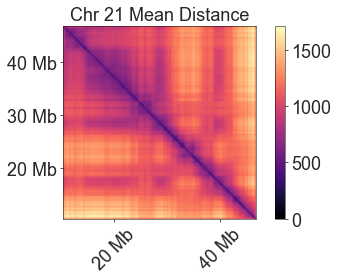

In [15]:
from plot_functions import plot_msd_map, plot_contact_map, expected, draw_power_law_triangle

start_Mb = data_combined['start_position_Mb'][0]
end_Mb = data_combined['end_position_Mb'][-1]
print(start_Mb)
print(end_Mb)
plot_msd_map(mean_distance_map, start_Mb, end_Mb, 'chr_21', chrom='21')

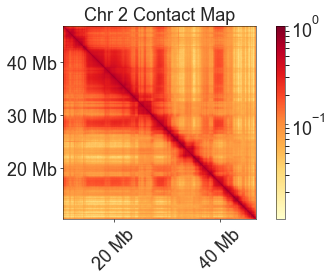

In [16]:
plot_contact_map(contact_map, start_Mb, end_Mb, 'chr21')

In [17]:
from scipy.stats import linregress
from scipy.ndimage import gaussian_filter
## compartment calling by PCA

#for contact_gaussian_sigma in np.arange(0,3,0.03):
# Generate correlation map
contact_gaussian_sigma = 1.9
hic_gaussian_sigma = 1.9
# normalize genomic distance effects
genomic_distance_map = squareform(pdist(data_combined['mid_position_Mb'][:,np.newaxis]))
genomic_distance_entries = genomic_distance_map[np.triu_indices(len(genomic_distance_map),1)]

# normalize genomic distance effects
contact_entries = contact_map[np.triu_indices(len(contact_map),1)]
kept = (genomic_distance_entries > 0) * (contact_entries > 0)
contact_lr = linregress(np.log(genomic_distance_entries[kept]), np.log(contact_entries[kept]))

#compute Pearson correlation matrix
#print(contact_lr)
contact_norm_map = np.exp(np.log(genomic_distance_map) * contact_lr.slope + contact_lr.intercept)
#for _i in range(len(normalization_mat)):
#    contact_norm_map[_i,_i] = 1
contact_normed_map = contact_map / contact_norm_map
# apply gaussian
contact_corr_map_combined = np.corrcoef(gaussian_filter(contact_normed_map, contact_gaussian_sigma))

/tmp/ipykernel_10083/946104313.py:20: RuntimeWarning: divide by zero encountered in log
  contact_norm_map = np.exp(np.log(genomic_distance_map) * contact_lr.slope + contact_lr.intercept)


Text(0.5, 1.0, 'Chr 21 obs/exp')

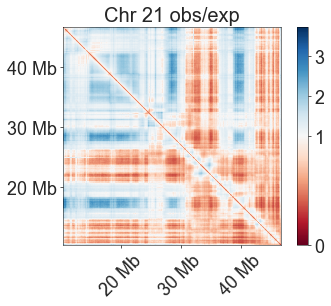

In [37]:
from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vcenter=1.0)

fig, ax = plt.subplots()
im = plt.imshow(contact_normed_map, cmap='RdBu', norm=divnorm,
               extent=[start_Mb*10**6, end_Mb*10**6,
                       start_Mb*10**6, end_Mb*10**6])
format_ticks(ax)
plt.colorbar(im, ax=ax)
ax.set_title("Chr 21 obs/exp")

In [51]:
#literal obs/ecp without fitting to a power law

def obs_exp(mat, mask=None):
    """ Compute observed over expected from raw contact map by dividing each diagonal by the mean.
    
    Parameters
    ----------
    mat : np.ndarray[float] (N, N)
        contact map
    mask : np.ndarray[bool] (N, N)
        regions that are masked out
    """
    Pofs = np.zeros((mat.shape[0],))
    Pofs[0] = 1.0 #main diagonal -- 100% probability of contact
    if mask is None:
        mask = np.ones(mat.shape, dtype="bool")
    for k in range(1, mat.shape[0]):
        diag = np.diag(mat, k)
        mask_diag = np.diag(mask, k)
        Pofs[k] = np.nanmean(diag[mask_diag])
    exp = LazyToeplitz(Pofs)
    oe = mat / exp[:, :]
    return oe, Pofs

obs_exp_chr21, Pofs = obs_exp(contact_map, mask=~np.isnan(contact_map))
obs_exp_chr21.shape

(651, 651)

Text(0.5, 1.0, 'Chr 21 obs/exp')

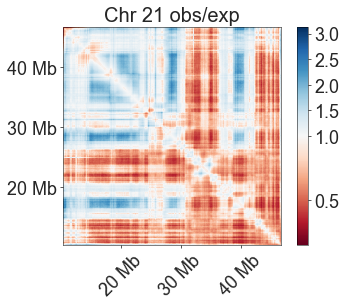

In [52]:
divnorm=colors.TwoSlopeNorm(vcenter=1.0)

fig, ax = plt.subplots()
im = plt.imshow(obs_exp_chr21, cmap='RdBu', norm=divnorm,
               extent=[start_Mb*10**6, end_Mb*10**6,
                       start_Mb*10**6, end_Mb*10**6])
format_ticks(ax)
plt.colorbar(im, ax=ax)
ax.set_title("Chr 21 obs/exp")

Text(0.5, 1.0, 'Chr 21 pearson correlation')

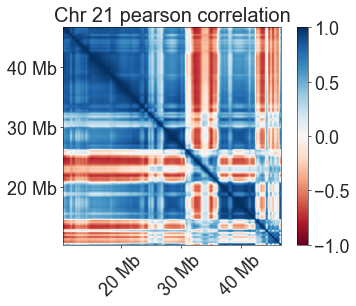

In [23]:
from plot_functions import format_ticks

fig, ax = plt.subplots()
im = plt.imshow(contact_corr_map_combined, cmap='RdBu', vmin=-1, vmax=1,
               extent=[start_Mb*10**6, end_Mb*10**6,
                       start_Mb*10**6, end_Mb*10**6])
format_ticks(ax)
plt.colorbar(im, ax=ax)
ax.set_title("Chr 21 pearson correlation")

In [38]:
#compute compartment score 2 from imaging data
def compute_comp_score(contactmap, ids=None):
    """ Compute COMP score 2 as a function of distance from diagonal.
    
    Parameters
    ----------
    contactmap : array-like
        N x N matrix
    compids : np.ndarray (N,)
        array where -2 is type A and 1 is type B
    
    """
    if ids is None:
        ids = np.load('/net/levsha/share/deepti/data/ABidentities_chr21_Su2020.npy')
    N = len(ids)
    assert(N == 651)
    monomer_ids = np.zeros((N,), dtype=int)
    monomer_ids[ids==0] = 1 #type B(cold)
    monomer_ids[ids==1] = -2 #type A (hot)
    ABidentities = np.outer(monomer_ids, monomer_ids)
    N = contactmap.shape[0]
    s = np.arange(1, N)
    contacts_within_A = np.zeros(N-1)
    pairs_within_A = np.zeros(N-1)
    contacts_within_B = np.zeros(N-1)
    pairs_within_B = np.zeros(N-1)
    pairs_across_comp = np.zeros(N-1)
    contacts_across_comp = np.zeros(N-1)

    for i, k in enumerate(s):
        diag_map = np.diag(contactmap, k)
        diag_AB = np.diag(ABidentities, k)
        contacts_within_A[i] = np.sum(diag_map[diag_AB == 4])
        pairs_within_A[i] = np.sum(diag_AB == 4)
        contacts_within_B[i] = np.sum(diag_map[diag_AB == 1])
        pairs_within_B[i] = np.sum(diag_AB == 1)
        contacts_across_comp[i] = np.sum(diag_map[diag_AB < 0])
        pairs_across_comp[i] = np.sum(diag_AB < 0)
    
    av_withinA_s = contacts_within_A / pairs_within_A
    av_withinB_s = contacts_within_B / pairs_within_B
    av_across_s = contacts_across_comp / pairs_across_comp
    av_within_s = (contacts_within_A + contacts_within_B) / (pairs_within_A + pairs_within_B)
    COMPscore1 = (av_within_s - av_across_s)/(av_within_s + av_across_s)
    COMPscore1_A = (av_withinA_s - av_across_s)/(av_withinA_s + av_across_s)
    COMPscore1_B = (av_withinB_s - av_across_s)/(av_withinB_s + av_across_s)
    return COMPscore1, COMPscore1_A, COMPscore1_B

/tmp/ipykernel_10083/866397209.py:40: RuntimeWarning: invalid value encountered in true_divide
  av_withinA_s = contacts_within_A / pairs_within_A
/tmp/ipykernel_10083/866397209.py:41: RuntimeWarning: invalid value encountered in true_divide
  av_withinB_s = contacts_within_B / pairs_within_B
/tmp/ipykernel_10083/866397209.py:43: RuntimeWarning: invalid value encountered in true_divide
  av_within_s = (contacts_within_A + contacts_within_B) / (pairs_within_A + pairs_within_B)


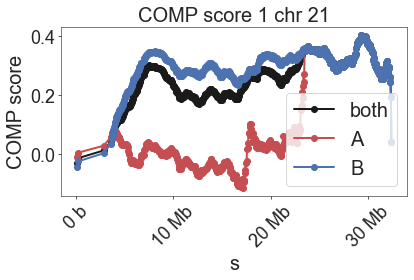

In [39]:
cs, csA, csB = compute_comp_score(contact_map)
fig, ax = plt.subplots()
sdistances = np.cumsum(np.diff(data_combined['mid_position_Mb']))*10**6
ax.plot(sdistances, cs, 'k-o', label='both')
ax.plot(sdistances, csA, 'r-o', label='A')
ax.plot(sdistances, csB, 'b-o', label='B')
plt.legend()
format_ticks(ax, y=False)
ax.set_xlabel('s')
ax.set_ylabel('COMP score')
ax.set_title('COMP score 1 chr 21')
fig.tight_layout()

In [46]:
csB[~np.isnan(cs) & (sdistances <= 30*10**6) & (sdistances >= 8*10**6)].mean()

3.106628659894521e-01

In [48]:
csA[~np.isnan(csA) & (sdistances <= 30*10**6) & (sdistances >= 8*10**6)].mean()

-0.0005783673557093417

In [60]:
np.nanmean(data_combined['segregation_scores'])

0.7451344714121315

In [61]:
np.nanstd(data_combined['segregation_scores'])

0.08245261224324432

In [62]:
np.nanmean(data_combined['randomized_segregation_scores'])

0.5108576255002122

In [63]:
np.nanstd(data_combined['randomized_segregation_scores'])

0.06408020652666871